<a href="https://colab.research.google.com/github/LeslyJaramillo/INTELIGENCIA-ARTIFICIAL/blob/main/MMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial.distance import cdist, squareform

In [ ]:
# Cargar el dataset de Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Definición de la capa de Sampling (Muestreo)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Función para el kernel Gaussiano
def gaussian_kernel(x, z, sigma=1):
    x_expanded = tf.expand_dims(x, axis=1)  # Shape: (batch_size_x, 1, d)
    z_expanded_t = tf.expand_dims(z, axis=0)  # Shape: (1, batch_size_z, d)
    pairwise_sq_dists = tf.reduce_sum(tf.square(x_expanded - z_expanded_t), axis=-1)
    kernel = tf.exp(-pairwise_sq_dists / (2.0 * sigma ** 2))
    return kernel

In [ ]:
# Función de pérdida MMD
def mmd_loss(x, y, sigma=1):
    k_xx = gaussian_kernel(x, x, sigma)
    k_yy = gaussian_kernel(y, y, sigma)
    k_xy = gaussian_kernel(x, y, sigma)
    # Cálculo de MMD
    mmd = tf.reduce_mean(k_xx) + tf.reduce_mean(k_yy) - 2 * tf.reduce_mean(k_xy)
    return tf.sqrt(tf.maximum(mmd, 0.0))


In [ ]:
# Definición del Modelo VAE
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)
        ])

        self.sampling = Sampling()

        self.decoder = tf.keras.Sequential([
            layers.Dense(7 * 7 * 64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid')
        ])


In [ ]:
# Definición del Modelo VAE
class VAE(Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)  # Produce z_mean y z_log_var
        ])
        # Sampling layer
        self.sampling = Sampling()
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(7 * 7 * 64, activation='relu'),
            layers.Reshape((7, 7, 64)),
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            layers.Conv2DTranspose(1, 3, strides=1, padding='same', activation='sigmoid')
        ])

    def call(self, x):
        # Codificar
        x = self.encoder(x)
        z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
        # Muestreo
        z = self.sampling((z_mean, z_log_var))
        # Reconstrucción de la imagen
        reconstructed = self.decoder(z)
        return reconstructed, z_mean, z_log_var

    # Función de pérdida VAE con MMD en lugar de crossentropy
    def vae_loss(self, x, reconstructed, z_mean, z_log_var):
        # Pérdida MMD entre las imágenes originales y las reconstruidas
        reconstruction_loss = mmd_loss(x, reconstructed)

        # Pérdida de divergencia KL
        kl_loss = -0.5 * tf.reduce_mean(
           tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        return reconstruction_loss + 0.5 * kl_loss

    # Paso de entrenamiento
    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            reconstructed, z_mean, z_log_var = self(x)
            loss = self.vae_loss(x, reconstructed, z_mean, z_log_var)
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

In [ ]:
latent_dim = 64
vae = VAE(latent_dim)
batch_size = 128

In [ ]:
# Compilar el modelo
vae.compile(optimizer='adam')

# Entrenar el modelo VAE
vae.fit(x_train, epochs=50, batch_size=batch_size)

# Generar nuevas imágenes usando el VAE
vae_imgs, _, _ = vae.predict(x_test)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 0.0696
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0366
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0359
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0360
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0352
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0353
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0349
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0345
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0354
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0351
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0351
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0352
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0343
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0346
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - 

In [ ]:
def compute_kernel_matrix(x, y, sigma=1):
    D = cdist(x.reshape(-1, 28*28), y.reshape(-1, 28*28))
    sig = np.median(D)
    k = np.exp((-D**2) / (2 * sig**2))
    return k

k_matrix = compute_kernel_matrix(x_test, vae_imgs)

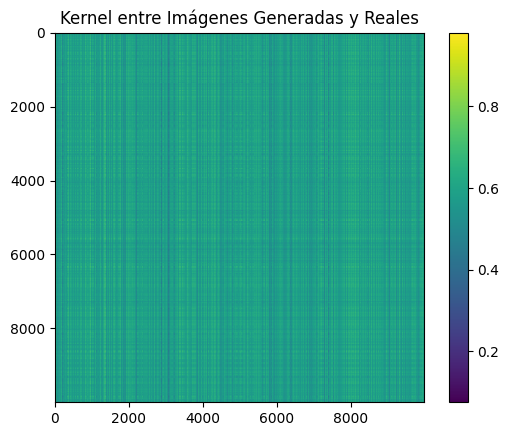

In [ ]:

plt.imshow(k_matrix, cmap='viridis')
plt.colorbar()
plt.title("Kernel entre Imágenes Generadas y Reales")
plt.show()


